In [87]:
import base64
import operator, textwrap, dotenv

dotenv.load_dotenv()

from langchain.chat_models import init_chat_model
from langgraph.types import Send, interrupt
from typing_extensions import Annotated

from langgraph.graph import END, START, StateGraph
from typing import TypedDict
import subprocess

# 오픈 AI 직접 사용 하는 방식.
from openai import OpenAI

llm = init_chat_model("openai:gpt-4o-mini")


class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    thumbnail_prompt: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]
    mega_summarys: str
    user_feedback: str
    chosen_prompt: str


def extract_audio(state: State):
    output_file = state["video_file"].replace(".mp4", ".mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]
    subprocess.run(command)
    return {
        "audio_file": output_file,
    }


def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="ko",
            prompt="유발하라리, 넥서스, 책 요약"
        )
        return {
            "transcription": transcription
        }


def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({
            "id": i + 1,
            "chunk": chunk
        })
    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):
    chunk_id = chunk["id"]
    chunk_text = chunk["chunk"]
    response = llm.invoke(
        f"""
        이 텍스트들을 보기좋게 요약을 해주세요. 한국어 입니다.
        텍스트: {chunk_text}
        """
    )
    summary = f"[Chunk {chunk_id}] {response.content}"
    return {
        "summaries": [summary]
    }


def mega_summary(state: State):
    all_summaries = "/n".join(state["summaries"])
    prompt = f"""
    요약본을 바탕으로 핵심키워드를 추출해서 요약본을 설명하는 요약본을 만들어줘 약 500자 내외면 좋겠어.
    요약본:{all_summaries}
    """
    response = llm.invoke(prompt)
    return {"mega_summarys": response.content}


def dispatch_artists(state: State):
    return [
        Send(
            "generate_thumbnail", {
                "id": i,
                "summary": state["mega_summarys"]
            }
        ) for i in [1, 2, 3]
    ]


def generate_thumbnail(args):
    concept_id = args["id"]
    summary = args["summary"]

    prompt = f"""
    이 요약본을 바탕으로, GPT images 생성기에 입력할 유튜브 썸네일을 만들기 위한 프롬프트를 만들어줘,
    - 핵심적인 시각적 요소가 2~3개 포함되어야 하고 너무 많은 요소가 들어가지 않도록 해줘,
    - 색상의 균형이 중요해,
    - 타이틀이 들어갈 위치에 핵심키워드를 넣어줘.
    요약본 : {summary}
    """

    response = llm.invoke(prompt)

    thumbnail_prompt = response.content

    client = OpenAI()

    result = client.images.generate(
        model="gpt-image-1",
        prompt=thumbnail_prompt,
        quality="low",
        moderation="low",
        size="auto"
    )

    image_bytes = base64.b64decode(result.data[0].b64_json)
    filename = f"thumbnail_{concept_id}.jpg"

    with open(filename, "wb") as file:
        file.write(image_bytes)

    return {
        "thumbnail_prompt": [thumbnail_prompt],
        "thumbnail_sketches": [filename],
    }


def human_feedback(state: State):
    answer = interrupt(
        {
            "chosen_thumbnail": "어떤 썸네일이 제일 마음에 드시나요? ",
            "feedback": "최종 썸네일을 제작하기 위한 피드백을 주세요"
        }
    )
    user_feedback = answer["user_feedback"]
    chosen_prompt = answer["chosen_prompt"]
    return {
        "user_feedback": user_feedback,
        "chosen_prompt": state["thumbnail_prompt"][chosen_prompt - 1],
    }


def generate_hd_thumbnail(state: State):
    chosen_prompt = state["chosen_prompt"]
    user_feedback = state["user_feedback"]

    prompt = f"""
    당신은 전문 유튜브 썸네일 디자이너입니다. 원본 썸네일 프롬프트를 가지고 사용자의 구체적인 피드백을 통합하여 개선된 버전을 만드세요.

    **원본 프롬프트 (ORIGINAL PROMPT):**
    {chosen_prompt}

    **통합할 사용자 피드백 (USER FEEDBACK TO INCORPORATE):**
    {user_feedback}

    다음과 같은 내용을 담아 개선된 프롬프트를 만드세요:
    1.  원본 프롬프트의 **핵심 개념을 유지**합니다.
    2.  사용자가 요청한 피드백을 **구체적으로 다루고 구현**합니다.
    3.  전문 유튜브 썸네일 제작 사양을 추가합니다:
        * **고대비** 및 **굵고 선명한 시각적 요소**
        * 시선을 사로잡는 **명확한 초점**
        * **전문적인 조명과 구도**
        * 가장자리에서 충분히 떨어지도록 **여백(패딩)을 넉넉하게 적용**한 **최적의 텍스트 배치 및 가독성**
        * **주목을 끄는 톡톡 튀는 색상**
        * **작은 썸네일 크기에서도 잘 작동하는 요소**
        * **중요:** **항상** 텍스트와 이미지 경계 사이에 **충분한 여백/패딩을 확보**하세요.
    """

    hd_response = llm.invoke(prompt)

    final_thumbnail_prompt = hd_response.content

    client = OpenAI()

    result = client.images.generate(
        model="gpt-image-1",
        prompt=final_thumbnail_prompt,
        quality="high",
        moderation="low",
        size="auto",
    )

    image_bytes = base64.b64decode(result.data[0].b64_json)

    with open("thumbnail_final.jpg", "wb") as file:
        file.write(image_bytes)



In [88]:
from langgraph.checkpoint.memory import InMemorySaver

graph_builder = StateGraph(State)

(
    graph_builder

    .add_node("extract_audio", extract_audio)
    .add_node("transcribe_audio", transcribe_audio)
    .add_node("dispatch_summarizers", dispatch_summarizers)
    .add_node("summarize_chunk", summarize_chunk)
    .add_node("mega_summary", mega_summary)
    .add_node("dispatch_artists", dispatch_artists)
    .add_node("generate_thumbnail", generate_thumbnail)
    .add_node("human_feedback", human_feedback)
    .add_node("generate_hd_thumbnail", generate_hd_thumbnail)

    .add_edge(START, "extract_audio")
    .add_edge("extract_audio", "transcribe_audio")
    .add_conditional_edges("transcribe_audio", dispatch_summarizers, ["summarize_chunk"])
    .add_edge("summarize_chunk", "mega_summary")
    .add_conditional_edges("mega_summary", dispatch_artists, ["generate_thumbnail"])
    .add_edge("generate_thumbnail", "human_feedback")
    .add_edge("human_feedback", "generate_hd_thumbnail")
    .add_edge("generate_hd_thumbnail", END)
)

memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {
    "configurable": {
        "thread_id": "3",
    },
}

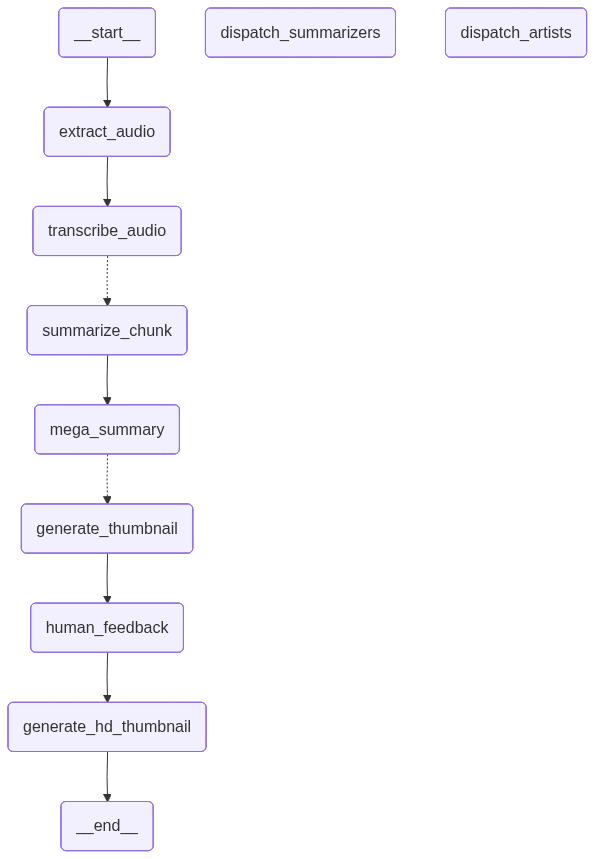

({'video_file': 'video.mp4',
  'audio_file': 'video.mp3',
  'transcription': '네, 안녕하세요. 오늘 책도, 오늘 아침에 읽은 책도, 여기 보이시죠? 넥서스입니다, 넥서스. 오늘도 제가 아침에 책을 읽었고요. 이렇게 1차적으로는 수첩에다가 이렇게 적습니다. 1차적으로 좋은 문장들을 적고, 이렇게 문장들을 적은 다음에 적고, 제가 챕터별로 딱 3개의 문장만 뽑아서 살짝 제 스타일대로 요약을 합니다. 요약을 하고 나서 질문 하나씩 적고, 답변을 다는 방식으로 이렇게 준비를 하고 있습니다. 지금 이틀 정도 해봤는데 상당히 좋은 것 같아요. 책의 내용도 많이 기억에 남고, 요약을 하다보니까 더 많은 생각을 할 수 있게 되고 그런 것 같습니다. 그래서 일단 잠깐 보시면, 짜잔, 넥서스죠? 저번 1편에서도 보여드리긴 했는데, 이번 하루의 책이고요. 오늘은 목차를 보면, 저번 영상에서는 프로로그를 담았고, 이번에는 정보란 무엇인가, 정보가 뭔지, 그리고 이야기, 이야기에 대한 두 장을 제가 요약을 했고요. 보시면 정보란 무엇인가, 여기서 인상 깊었던 구절을 제가 조금 변형해서 적어봤습니다. 책 이름이 넥서스인데, 궁극적으로는 각 개인은 서로 다른 세계관을 가지며, 그것은 그 사람의 성격과 인생사가 교차하면 형성된다. 정보란 무엇인가잖아요? 정보는 사회적 연결고리, 넥서스라는 거죠. 그러니까 종이랑 종이랑 붙이는 풀처럼 사람들을 연결해주는 사회적 연결고리가 넥서스고, 그것도 정보를 정의한다고 얘기를 하는 것 같습니다. 사람들은 정말 서로 다른 세계관을 가지죠. 그래서 여러분들의 세계관은, 그 세계관에서는 무엇이 가치 있다고 생각하시는지, 이걸 한번 생각해보시면 좋을 것 같아요. 두 번째입니다. 이 문장도 참 좋았는데요. 과학적이나 정치 연설 같은 몇 가지 유형의 정보는, 사람들에게 현실을 정확하게 표현해서 사람들을 하나로 묶으려고 하죠. 그런데 사람들을 묶는데 효과적인 정보는 이런 사실이 아니고, 허구인 매력적인 

In [89]:
from langgraph.types import Command

display(graph)
graph.invoke(
    {'video_file': 'video.mp4'},
    config=config
),



In [90]:
response = {
    "user_feedback": "약간 3d 느낌을 추가해주고, 캐릭터 느낌으로 부탁해, 그리고 좌우 대칭이 잘 맞도록 이미지를 만들어줘",
    "chosen_prompt": 2,
}

graph.invoke(
    Command(resume=response),
    config=config,
)

{'video_file': 'video.mp4',
 'audio_file': 'video.mp3',
 'transcription': '네, 안녕하세요. 오늘 책도, 오늘 아침에 읽은 책도, 여기 보이시죠? 넥서스입니다, 넥서스. 오늘도 제가 아침에 책을 읽었고요. 이렇게 1차적으로는 수첩에다가 이렇게 적습니다. 1차적으로 좋은 문장들을 적고, 이렇게 문장들을 적은 다음에 적고, 제가 챕터별로 딱 3개의 문장만 뽑아서 살짝 제 스타일대로 요약을 합니다. 요약을 하고 나서 질문 하나씩 적고, 답변을 다는 방식으로 이렇게 준비를 하고 있습니다. 지금 이틀 정도 해봤는데 상당히 좋은 것 같아요. 책의 내용도 많이 기억에 남고, 요약을 하다보니까 더 많은 생각을 할 수 있게 되고 그런 것 같습니다. 그래서 일단 잠깐 보시면, 짜잔, 넥서스죠? 저번 1편에서도 보여드리긴 했는데, 이번 하루의 책이고요. 오늘은 목차를 보면, 저번 영상에서는 프로로그를 담았고, 이번에는 정보란 무엇인가, 정보가 뭔지, 그리고 이야기, 이야기에 대한 두 장을 제가 요약을 했고요. 보시면 정보란 무엇인가, 여기서 인상 깊었던 구절을 제가 조금 변형해서 적어봤습니다. 책 이름이 넥서스인데, 궁극적으로는 각 개인은 서로 다른 세계관을 가지며, 그것은 그 사람의 성격과 인생사가 교차하면 형성된다. 정보란 무엇인가잖아요? 정보는 사회적 연결고리, 넥서스라는 거죠. 그러니까 종이랑 종이랑 붙이는 풀처럼 사람들을 연결해주는 사회적 연결고리가 넥서스고, 그것도 정보를 정의한다고 얘기를 하는 것 같습니다. 사람들은 정말 서로 다른 세계관을 가지죠. 그래서 여러분들의 세계관은, 그 세계관에서는 무엇이 가치 있다고 생각하시는지, 이걸 한번 생각해보시면 좋을 것 같아요. 두 번째입니다. 이 문장도 참 좋았는데요. 과학적이나 정치 연설 같은 몇 가지 유형의 정보는, 사람들에게 현실을 정확하게 표현해서 사람들을 하나로 묶으려고 하죠. 그런데 사람들을 묶는데 효과적인 정보는 이런 사실이 아니고, 허구인 매력적인 정보가